In [127]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob
import pandas as pd
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord

In [132]:
# Failed attempt to crossmatch the sample with datasets for initial guess
# Using my current estimates instead
# For stars without calibrated pars (using Anna's relation)
# estimate based on summary plots.

# star_hdus = fits.open('../../Fa2020_MW_substructure/data/dr6_v2_stellar_LRS.fits')
# arr_l6 = star_hdus[1].data
# star_hdus.close()

# df_all = pd.read_csv('../data/SkyMapper_MIKE_Observations_w_RV.csv')
# N_star = len(df_all)
# N_sample = 1e4

# # Compute the galactic coordinate and put them in the df
# c_input = SkyCoord(ra=df_all['RA'].values*u.deg,dec=df_all['DEC'].values*u.deg)
# # Get initial guess of stellar parameters and their uncertainties from SSPP
# catalog = SkyCoord(ra=arr_l6['ra']*u.degree, dec=arr_l6['dec']*u.degree)
# idx, d2d, d3d = c_input.match_to_catalog_3d(catalog)
# # Add the sdss dr16 redshifts to the data frame
# temp_ind = (d2d < 3*u.arcsec)

# ind_matched = np.arange(N_star)[temp_ind]

In [105]:
# print(df_all.head())
# print(df_JHK.head())
df_EBV['|E_B_V_SandF'].values

array([0.1178, 0.1315, 0.0851, 0.0333, 0.039 , 0.0564, 0.0329, 0.0412,
       0.0562, 0.0835, 0.0709, 0.0359, 0.072 , 0.1163, 0.1115, 0.0787,
       0.1435, 0.0963, 0.1978, 0.1306, 0.131 , 0.042 , 0.0576, 0.0509,
       0.0318, 0.0453, 0.0699, 0.0575, 0.0701, 0.0824, 0.0532, 0.1198,
       0.0599, 0.0726, 0.0866, 0.1154, 0.0902, 0.0898, 0.0665, 0.0588,
       0.0448, 0.2991, 0.1275, 0.1355, 0.177 , 0.1181, 0.1415, 0.1215,
       0.0139, 0.1209, 0.0181, 0.0104, 0.0768, 0.0498, 0.0986, 0.0701,
       0.1266, 0.2618, 0.0979, 0.0196, 0.1956, 0.0293, 0.0203, 0.0204,
       0.0464, 0.0086, 0.0372, 0.0524, 0.0499, 0.1747, 0.1306, 0.096 ,
       0.2624, 0.1455, 0.246 , 0.1537, 0.1912, 0.1308, 0.0916, 0.0649,
       0.0851, 0.0596, 0.0293, 0.0317, 0.0066, 0.0249, 0.0181, 0.0133])

In [426]:
# Export a list of just ra and dec for later crossmatching
# df_all.to_csv('../data/SMSS88_ra_dec_for_query.csv', columns=['RA','DEC'],index=False)
# Export a list of just logg, feh, and teff for finding BC_V
df_all = pd.read_csv('../data/SkyMapper_MIKE_Observations_w_RV.csv')
df_par_ini = df_all.loc[:,['logg_ini','feh_ini','teff_ini']]
# Create duplicates of the stellar par initial guess with e_teff = 200 and e_logg = 0.3
par_ini_dup_name = ['teff_ini','logg_ini']
par_ini_dup_err = [200,0.3]

df_par_dup1 = df_par_ini.copy()
df_par_dup1[par_ini_dup_name[0]] = df_par_dup1[par_ini_dup_name[0]] + par_ini_dup_err[0]
df_par_dup1[par_ini_dup_name[1]] = df_par_dup1[par_ini_dup_name[1]] + par_ini_dup_err[1]

df_par_dup2 = df_par_ini.copy()
df_par_dup2[par_ini_dup_name[0]] = df_par_dup2[par_ini_dup_name[0]] - par_ini_dup_err[0]
df_par_dup2[par_ini_dup_name[1]] = df_par_dup2[par_ini_dup_name[1]] - par_ini_dup_err[1]

df_par_ini_for_bcv = pd.concat([df_par_ini,df_par_dup1,df_par_dup2])

# Compute the galactic coordinate and put them in the df
c_input = SkyCoord(ra=df_all['RA'].values*u.deg,dec=df_all['DEC'].values*u.deg)
c_input_gal = c_input.galactic
df_all['l'], df_all['b'] = c_input_gal.l, c_input_gal.b

In [496]:
# Since BC codes only handles one E(B-V) at a time
# Manualy loop through all stars to get their BCV and e_BCV

# Get E(B-V) and their uncertainties from https://irsa.ipac.caltech.edu/applications/DUST/
# by uploading a table
df_EBV = pd.read_csv('../data/SMSS88_EBV.csv',comment='#',delim_whitespace=True)

df_mm = pd.read_csv('../data/Full_catalog_plx_corr_dists_stellar_params_kinematics.csv',skip_blank_lines=False)


# Apply reddening correction for stars based on their distances and galactic latitude
h = 0.125
for i in range(len(df_all)):
    if df_EBV.loc[i,'|E_B_V_SandF'] > 0.1:
        # Using inverse of plx for dist for consistency
        dist = 1/df_mm.loc[i,'Corrected_Parallax']
        b_tmp = df_all.loc[i,'b']
        ebv_mod = df_EBV.loc[i,'|E_B_V_SandF']*(1-np.exp(-np.abs(dist*np.sin(b_tmp*np.pi/180)/h)))
        print('Use E(B-V)_mod =',ebv_mod, 'for', df_mm.loc[i,'name'],'at i=',i,'with d =',dist,'kpc')
i = 77
print('Use E(B-V) =',df_EBV.loc[i,'|E_B_V_SandF'])

df_par_ini_for_bcv.loc[[i],['logg_ini','feh_ini','teff_ini']].to_csv('../data/BC_for_stellar_param/BCcodes/input.sample',header=False,index=False,sep=' ',float_format='%.2f')

Use E(B-V)_mod = 0.11775631334144938 for b'SMSS5' at i= 0 with d = 2.687892409939861 kpc
Use E(B-V)_mod = 0.13149891931316093 for b'SMSS6' at i= 1 with d = 3.8677846491353556 kpc
Use E(B-V)_mod = 0.11629989865419113 for b'SMSS38' at i= 13 with d = 3.400724026586915 kpc
Use E(B-V)_mod = 0.11149928502735783 for b'SMSS39' at i= 14 with d = 2.8964407036698043 kpc
Use E(B-V)_mod = 0.14349921405794014 for b'SMSS43' at i= 16 with d = 3.136443854399283 kpc
Use E(B-V)_mod = 0.19500302887452747 for b'SMSS51' at i= 18 with d = 1.165039941984065 kpc
Use E(B-V)_mod = 0.13059998518270624 for b'SMSS58' at i= 19 with d = 3.3629625305258335 kpc
Use E(B-V)_mod = 0.1309997088354202 for b'SMSS64' at i= 20 with d = 3.5967056092207046 kpc
Use E(B-V)_mod = 0.11974130407821262 for b'SMSS1_22' at i= 31 with d = 3.5937832318635046 kpc
Use E(B-V)_mod = 0.11535407991739935 for b'SMSS1_31' at i= 35 with d = 3.8865260336516547 kpc
Use E(B-V)_mod = 0.269214620251722 for b'SMSS343' at i= 41 with d = 2.015718560137151

In [556]:
V_J_coeff = np.array([0.4669,0.3849,-0.0350,-0.0140,0.0225,0.0011])
V_H_coeff = np.array([0.5251,0.2553,-0.0119,-0.0187,0.0410,0.0025])
V_K_coeff = np.array([0.5057,0.2600,-0.0146,-0.0131,0.0288,0.0016])
J_K_coeff = np.array([0.6393,0.6104,0.0920,-0.0330,0.0291,0.0020])
C10scatter = np.array([42,33,25,132])

color_up_bound = np.array([2.44,3.01,3.15,0.80])
color_lo_bound = np.array([0.61,0.67,0.78,0.07])

def c10_color_feh_teff_fundamental_logg(feh,e_feh,bcv,e_bcv,df_input,ian_eq=False):
    # Iterate thorugh each star in the list 
    N_star=len(df_input)
    
    teff_w_mean_arr = np.zeros(N_star)
    teff_w_std_arr = np.zeros(N_star)
    teff_V_J_mean_arr, teff_V_J_std_arr = np.zeros(N_star), np.zeros(N_star)
    teff_V_H_mean_arr, teff_V_H_std_arr = np.zeros(N_star), np.zeros(N_star)
    teff_V_K_mean_arr, teff_V_K_std_arr = np.zeros(N_star), np.zeros(N_star)
    teff_J_K_mean_arr, teff_J_K_std_arr = np.zeros(N_star), np.zeros(N_star)
    logg_med_arr = np.zeros(N_star)
    logg_std_arr = np.zeros(N_star)
    
    # Get the mass resampling, which is the same for all stars
    # in unit of solar mass
    M_sample = np.random.normal(0.8,0.08,N_sample)
    
    for i in range(N_star):
        # Get the reduced E(B-V) resampled
        ebv_mean, eebv_std = df_all.loc[i,'EBV'], df_all.loc[i,'e_EBV']
        ebv_sample = np.random.normal(ebv_mean,eebv_std,N_sample)
        
        # Get the plx sample pd.to_numeric(df_BVJHK.loc[i,'BTmag'],errors='coerce')
        plx_mean, plx_std = pd.to_numeric(df_input.loc[i,'plx'],errors='coerce'), pd.to_numeric(df_input.loc[i,'e_plx'],errors='coerce')
        plx_sample = np.random.normal(plx_mean, plx_std, N_sample)
        # Remove any negative plx from resampling
        for j in range(N_sample):
            plx_sample[j] = max(plx_sample[j],0.000001)
        
        # Modify the E(B-V) if > 0.1
        if ebv_mean > 0.1:
            # Using inverse of plx for dist for consistency
            dist_sample = 1/plx_sample
            b_tmp = df_all.loc[i,'b']
            if ian_eq == False:
                ebv_sample = ebv_sample*(1-np.exp(-np.abs(dist_sample*np.sin(b_tmp*np.pi/180)/h)))
            else:
                ebv_mean_mod = ebv_mean*(1-np.exp(-np.abs(dist_sample*np.sin(b_tmp*np.pi/180)/h)))
                ebv_sample = ebv_mean_mod + np.random.normal(0,eebv_std,N_sample)
            df_all.loc[i,'EBV_mod_flg'] = 1
        
        # Remove any negative E(B-V) from resampling
        for j in range(N_sample):
            ebv_sample[j] = max(ebv_sample[j],0.0)
        
        # Get the magnitudes and their uncertainties
        mag_mean = df_input.loc[i,mag_name].astype('float').values
        mag_err = df_input.loc[i,e_mag_name].astype('float').values
        
        # Resample 10^4 times assuming normal distribution
        B_sample = np.random.normal(mag_mean[0],mag_err[0],N_sample)
        V_sample = np.random.normal(mag_mean[1],mag_err[1],N_sample)
        J_sample = np.random.normal(mag_mean[2],mag_err[2],N_sample)
        H_sample = np.random.normal(mag_mean[3],mag_err[3],N_sample)
        K_sample = np.random.normal(mag_mean[4],mag_err[4],N_sample)
        
        # Put them together and create temp list for later use
        mag_sample = [B_sample,V_sample,J_sample,H_sample,K_sample]
        magdered_sample = [np.zeros(N_sample)]*len(R_lbd)
        
        # Get the dereddened magnitudes with 0.01 error assumed in R_lbda
        # Also store the resampled R_lbd for later use
        R_lbd_sample_list = []
        for j in range(len(R_lbd)):
            R_lbd_sample = np.random.normal(R_lbd[j],0.01,N_sample)
            R_lbd_sample_list.append(R_lbd_sample)
            A_lbd_sample = R_lbd_sample*ebv_sample
            magdered_sample[j] = mag_sample[j] - A_lbd_sample
        
        magdered_mean = [np.mean(x) for x in magdered_sample]
        
        # Raise an flag if the mean color is outside of applicable range
        if magdered_mean[1]-magdered_mean[2] < color_lo_bound[0] or magdered_mean[1]-magdered_mean[2] > color_up_bound[0] \
        or magdered_mean[1]-magdered_mean[3] < color_lo_bound[1] or magdered_mean[1]-magdered_mean[3] > color_up_bound[1] \
        or magdered_mean[1]-magdered_mean[4] < color_lo_bound[2] or magdered_mean[1]-magdered_mean[4] > color_up_bound[2] \
        or magdered_mean[2]-magdered_mean[4] < color_lo_bound[3] or magdered_mean[2]-magdered_mean[4] > color_up_bound[3]:
            print('Star index:',i,'has mean color outside of the applicable range!')
        
        # Get the [Fe/H] and its uncertainty
        feh_mean = feh[i]
        feh_err = e_feh[i]
        feh_sample = np.random.normal(feh_mean,feh_err,N_sample)
        
        # Get the colors
        if ian_eq == False:
            V_J_sample = magdered_sample[1]-magdered_sample[2]
            V_H_sample = magdered_sample[1]-magdered_sample[3]
            V_K_sample = magdered_sample[1]-magdered_sample[4]
            J_K_sample = magdered_sample[2]-magdered_sample[4]
        else:
            # Get the colors according to Ian's function
            V_J_sample = V_sample - J_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[1]-R_lbd_sample_list[2]))
            V_H_sample = V_sample - H_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[1]-R_lbd_sample_list[3]))
            V_K_sample = V_sample - K_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[1]-R_lbd_sample_list[4]))
            J_K_sample = J_sample - K_sample - ebv_sample/(R_lbd_sample_list[1]*(R_lbd_sample_list[2]-R_lbd_sample_list[4]))
        
        
        
        # Use the relation to get a sample of Teff
        teff_V_J_sample = 5040/(V_J_coeff[0] + V_J_coeff[1]*V_J_sample + V_J_coeff[2]*V_J_sample**2 + V_J_coeff[3]*V_J_sample*feh_sample +\
                          V_J_coeff[4]*feh_sample + V_J_coeff[5]*feh_sample**2)
        teff_V_H_sample = 5040/(V_H_coeff[0] + V_H_coeff[1]*V_H_sample + V_H_coeff[2]*V_H_sample**2 + V_H_coeff[3]*V_H_sample*feh_sample +\
                          V_H_coeff[4]*feh_sample + V_H_coeff[5]*feh_sample**2)
        teff_V_K_sample = 5040/(V_K_coeff[0] + V_K_coeff[1]*V_K_sample + V_K_coeff[2]*V_K_sample**2 + V_K_coeff[3]*V_K_sample*feh_sample +\
                          V_K_coeff[4]*feh_sample + V_K_coeff[5]*feh_sample**2)
        teff_J_K_sample = 5040/(J_K_coeff[0] + J_K_coeff[1]*J_K_sample + J_K_coeff[2]*J_K_sample**2 + J_K_coeff[3]*J_K_sample*feh_sample +\
                          J_K_coeff[4]*feh_sample + J_K_coeff[5]*feh_sample**2)
        
        # Plot the distribution of the colors and the resulting teff for debugging
        if i == 0:
            plt.hist(V_J_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('V-J')
            plt.show()
            
            plt.hist(teff_V_J_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('Teff V-J')
            plt.show()
            
            plt.hist(V_H_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('V-H')
            plt.show()
            
            plt.hist(teff_V_H_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('Teff V-H')
            plt.show()
            
            plt.hist(V_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('V-K')
            plt.show()
            
            plt.hist(teff_V_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('Teff V-K')
            plt.show()
            
            plt.hist(J_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('J-K')
            plt.show()
            
            plt.hist(teff_J_K_sample,bins=100,fc='none',ec='k',histtype=u'step')
            plt.title('Teff J-K')
            plt.show()
        
        
        # Find the mean and standard deviation
        teff_V_J_mean, teff_V_J_std = np.mean(teff_V_J_sample), np.std(teff_V_J_sample)
        teff_V_H_mean, teff_V_H_std = np.mean(teff_V_H_sample), np.std(teff_V_H_sample)
        teff_V_K_mean, teff_V_K_std = np.mean(teff_V_K_sample), np.std(teff_V_K_sample)
        teff_J_K_mean, teff_J_K_std = np.mean(teff_J_K_sample), np.std(teff_J_K_sample)
        
        # Compute weighted average and weighted std
        # Incorporate the intrinsic scatter of the relation
        teff_mean_arr = np.array([teff_V_J_mean,teff_V_H_mean,teff_V_K_mean,teff_J_K_mean])
        teff_std_arr = np.array([teff_V_J_std,teff_V_H_std,teff_V_K_std,teff_J_K_std])
        teff_std_arr_p_sca = np.sqrt(teff_std_arr**2+C10scatter**2)
        weight = 1/teff_std_arr_p_sca**2
        teff_w_mean = np.sum(weight*teff_mean_arr)/np.sum(weight)
        teff_w_std = np.sqrt(np.sum(weight*(teff_mean_arr-teff_w_mean)**2)/np.sum(weight)*4/3)
        
        
        teff_w_mean_arr[i], teff_w_std_arr[i] = teff_w_mean, teff_w_std
        teff_V_J_mean_arr[i], teff_V_J_std_arr[i] = teff_V_J_mean, teff_V_J_std
        teff_V_H_mean_arr[i], teff_V_H_std_arr[i] = teff_V_H_mean, teff_V_H_std
        teff_V_K_mean_arr[i], teff_V_K_std_arr[i] = teff_V_K_mean, teff_V_K_std
        teff_J_K_mean_arr[i], teff_J_K_std_arr[i] = teff_J_K_mean, teff_J_K_std
        
        # Now start to calculate log g
        # Get a new Teff resample with the added fudge factor
        # Add a fudge factor to account for systematics
        # (This might introduce some inconsistency...)
        teff_fudge = 250
        teff_w_std_f = np.sqrt(teff_w_std**2 + teff_fudge**2)
        teff_sample = np.random.normal(teff_w_mean, teff_w_std_f, N_sample)
        
        # Get the BC_V sample
        bcv_mean, bcv_std = bcv[i], e_bcv[i]
        bcv_sample = np.random.normal(bcv_mean, bcv_std, N_sample)
        
        # Calculate log g
        
        logg_sample = 4*np.log10(teff_sample) + np.log10(M_sample) - 10.61 + \
                      0.4*(bcv_sample + V_sample - 5*np.log10(1000/plx_sample) + \
                           5 - 3.1*ebv_sample - 4.75)
#         if i == 34: # For debugging
#             print(teff_sample[0],M_sample[0],bcv_sample[0],V_sample[0],plx_sample[0],ebv_sample[0])
        
        logg_med_arr[i], logg_std_arr[i] = np.nanmedian(logg_sample), np.nanstd(logg_sample)
    
    
    return teff_V_J_mean_arr, teff_V_J_std_arr, teff_V_H_mean_arr, teff_V_H_std_arr,\
           teff_V_K_mean_arr, teff_V_K_std_arr, teff_J_K_mean_arr, teff_J_K_std_arr,\
           teff_w_mean_arr, teff_w_std_arr, logg_med_arr, logg_std_arr

In [ ]:
# def fundamental_logg(teff,e_teff,bcv,e_bcv,df_input):
#     # Iterate thorugh each star in the list 
#     N_star=len(df_input)
    
#     logg_med = np.zeros(N_star)
#     logg_std = np.zeros(N_star)
    
#     # Get the mass resampling, which is the same for all stars
#     # in unit of solar mass
#     M = np.random.normal(0.8,0.08,N_sample)
#     for i in range(N_star):
#         # Get the Teff resample
#         teff_mean, teff_std = teff[i], e_teff[i]
#         # Add a fudge factor to account for systematics
#         teff_fudge = 250
#         teff_std = np.sqrt(teff_std**2 + teff_fudge**2)
#         teff_sample = np.random.normal(teff_mean, teff_std, N_sample)
        
#         # Get the BC_V sample
#         bcv_mean, bcv_std = bcv[i], e_bcv[i]
#         bcv_sample = np.random.normal(bcv_mean, bcv_std, N_sample)
        
#         # Get the V sample
#         Vmag_mean, Vmag_std = df_input.loc[i,'Vmag'].astype('float').values, df_input.loc[i,'e_Vmag'].astype('float').values
#         Vmag_sample = np.random.normal(Vmag_mean, Vmag_std, N_sample)
        
#         # Get the plx sample
#         plx_mean, plx_std = df_input.loc[i,'plx'].astype('float').values, df_input.loc[i,'e_plx'].astype('float').values
#         plx_sample = np.random.normal(plx_mean, plx_std, N_sample)
        
#         # Get the 

In [428]:
# import the 88 stars with thier position in the sky and radial velicities(don't need this one really, but well...)
df_all = pd.read_csv('../data/SkyMapper_MIKE_Observations_w_RV.csv')
N_star = len(df_all)
N_sample = int(1e4)

# Compute the galactic coordinate and put them in the df
c_input = SkyCoord(ra=df_all['RA'].values*u.deg,dec=df_all['DEC'].values*u.deg)
c_input_gal = c_input.galactic
df_all['l'], df_all['b'] = c_input_gal.l, c_input_gal.b
# put in Mohammad's distance measurement here
df_mm = pd.read_csv('../data/Full_catalog_plx_corr_dists_stellar_params_kinematics.csv',skip_blank_lines=False)
df_all['dist'], df_all['e_dist'] = df_mm['Distances_mardini'], df_mm['Distances_mardini_error']
df_all['plx'], df_all['e_plx'] = df_mm['Corrected_Parallax'], df_mm['parallax_error']

# Crossmatch the sample with 2MASS and APASS/Tycho-2
# to get photometry and their uncertainties 
# Minimum uncertainties as described in Ian's document
df_BVJHK = pd.read_csv('../data/SMSS88_BVJHK.csv',comment='#',sep=';')

# Take away duplicates in APASS that has no corresponding 2MASS
# Checked that the duplicates are surely the same object
df_BVJHK = df_BVJHK.drop(np.where((df_BVJHK['2MASS'].values) == '                 ')[0]).reset_index()

# Take the BVJHK magnitues and uncertainties into the main dataframe
df_all['Bmag'],df_all['e_Bmag'] = df_BVJHK['Bmag_A'].astype('float'), df_BVJHK['e_Bmag_A'].astype('float')
df_all['Vmag'],df_all['e_Vmag'] = df_BVJHK['Vmag_A'].astype('float'), df_BVJHK['e_Vmag_A'].astype('float')
df_all['Jmag'],df_all['e_Jmag'] = df_BVJHK['Jmag'].astype('float'), df_BVJHK['e_Jmag'].astype('float')
df_all['Hmag'],df_all['e_Hmag'] = df_BVJHK['Hmag'].astype('float'), df_BVJHK['e_Hmag'].astype('float')
df_all['Kmag'],df_all['e_Kmag'] = df_BVJHK['Kmag'].astype('float'), df_BVJHK['e_Kmag'].astype('float')
df_all['BVmag_source'] = ['APASS']*N_star

# Replace APASS BV with Tycho-2 BV if V < 9.0 or APASS value is absent
for i in range(N_star):
    if df_all.loc[i,'Vmag'] < 9.0 or np.isnan(df_all.loc[i,'Vmag']) == True:
        df_all.loc[i,'Bmag'] = pd.to_numeric(df_BVJHK.loc[i,'BTmag'],errors='coerce')
        df_all.loc[i,'e_Bmag'] = pd.to_numeric(df_BVJHK.loc[i,'e_BTmag'],errors='coerce')
        df_all.loc[i,'Vmag'] = pd.to_numeric(df_BVJHK.loc[i,'VTmag'],errors='coerce')
        df_all.loc[i,'e_Vmag'] = pd.to_numeric(df_BVJHK.loc[i,'e_VTmag'],errors='coerce')
        df_all.loc[i,'BVmag_source'] = 'Tycho-2'

# Set minimum errors for diff sources
e_mag_min_A = [0.0328,0.0323,0.02,0.02,0.02]
e_mag_min_T = [0.0294,0.0634,0.02,0.02,0.02]
e_mag_name = ['e_Bmag','e_Vmag','e_Jmag','e_Hmag','e_Kmag']
        
# Enforce the minimum and maximum uncertainty
for i in range(N_star):
    if df_all.loc[i,'BVmag_source'] == 'APASS':
        min_temp = e_mag_min_A
    else:
        min_temp = e_mag_min_T
    
    for j in range(len(e_mag_name)):
        # Enforce overall maximum bound
        if df_all.loc[i,e_mag_name[j]] > 0.25:
            df_all.loc[i,e_mag_name[j]] = 0.25
        # Enforce specific minimum bounds
        if df_all.loc[i,e_mag_name[j]] < min_temp[j]:
            df_all.loc[i,e_mag_name[j]] = min_temp[j]

            
# Get E(B-V) and their uncertainties from https://irsa.ipac.caltech.edu/applications/DUST/
# by uploading a table
df_EBV = pd.read_csv('../data/SMSS88_EBV.csv',comment='#',delim_whitespace=True)

# Get E(B-V)_mod using Gaia distances and uncertainties calculated by Mohammad (parallax corrected for zero offset)
# This modification is a bit debatable since a significant portion of my sample has bad parallax uncertainty
# Modify the E(B-V) if > 0.1
df_all['EBV'], df_all['e_EBV'] = df_EBV['|E_B_V_SandF'], df_EBV['|stdev_E_B_V_SandF']
df_all['EBV_mod_flg'] = [0]*N_star

h = 0.125 # scale height of the reddening layer in unit of kpc


# Use R_lambda from McCall Table 1 to get A_lambda and deredden the photometry magnitudes
R_lbd = [4.070,3.070,0.819,0.519,0.350]
A_lbd_name = ['A_B','A_V','A_J','A_H','A_K']
mag_name = ['Bmag','Vmag','Jmag','Hmag','Kmag']
# mag_dered_name = ['Bmag_dered','Vmag_dered','Jmag_dered','Hmag_dered','Kmag_dered']


# Feed the numbers into the relations (which comes with its own scatter) 
# and resample based on uncertainties 
# to get Teffs with errors from [Fe/H] and color and their errors 
# Error for [Fe/H] set to constant 0.15
# Get a Teff from weighted averages
df_all['teff_V_J_loop0'], df_all['e_teff_V_J_loop0'], df_all['teff_V_H_loop0'], df_all['e_teff_V_H_loop0'], \
df_all['teff_V_K_loop0'], df_all['e_teff_V_K_loop0'], df_all['teff_J_K_loop0'], df_all['e_teff_J_K_loop0'], \
df_all['teff_loop0'], df_all['e_teff_loop0'], df_all['logg_loop0'], df_all['e_logg_loop0'] \
= c10_color_feh_teff_fundamental_logg(df_all['feh_ini'].values,np.ones(N_star)*0.15,df_all['BCV_ini'].values,df_all['e_BCV_ini'].values,df_all)


# Use this Teff and fundamental relation to get log g
# the uncertainties included when available 
# Figure out the error on BC_V 
# Test how much BC_V changes when E(B-V) fluctuates in its error
# Using the a rough estimate for e_BCV: (BCV[teff+200,logg+0.3, E(B-V)]-BCV[teff-200,logg-0.3], E(B-V))/2
# The resulting error in BCV appears to only depend on teff and logg and their uncertainties,
# not so much on changes in E(B-V), which justifies the lack of varying E(B-V) for measuring error in E(B-V).
# For now, I would assume that BCV and e_BCV doesn't change from iteration to iteration, so long
# as teff and logg are not varying hugely between iteration.
# The process of getting BC_V is very painful at the moment...


# Use these Teff and logg with their uncertainties
# into SHMR and get [Fe/H] and its uncertainty (using script by Alex)
# Write out the result after this first loop (loop0)
df_all.to_csv('../data/SMSS88_loop0.csv',index=False)

# Repeat the process with the new [Fe/H]

In [429]:
# Read in the new [Fe/H] values
df_all = pd.read_csv('../data/SMSS88_loop0_w_feh.csv')

df_par_loop0 = df_all.loc[:,['logg_loop0','feh_loop0','teff_loop0']]
# Create duplicates of the stellar par initial guess with e_teff = 200 and e_logg = 0.3
par_ini_dup_name = ['teff_loop0','logg_loop0']
par_ini_dup_err = [200,0.3]

df_par_dup1 = df_par_loop0.copy()
df_par_dup1[par_ini_dup_name[0]] = df_par_dup1[par_ini_dup_name[0]] + par_ini_dup_err[0]
df_par_dup1[par_ini_dup_name[1]] = df_par_dup1[par_ini_dup_name[1]] + par_ini_dup_err[1]

df_par_dup2 = df_par_loop0.copy()
df_par_dup2[par_ini_dup_name[0]] = df_par_dup2[par_ini_dup_name[0]] - par_ini_dup_err[0]
df_par_dup2[par_ini_dup_name[1]] = df_par_dup2[par_ini_dup_name[1]] - par_ini_dup_err[1]

df_par_loop0_for_bcv = pd.concat([df_par_loop0,df_par_dup1,df_par_dup2])

# Since BC codes only handles one E(B-V) at a time
# Manualy loop through all stars to get their BCV and e_BCV

h = 0.125
i = 34

if df_all.loc[i,'EBV'] > 0.1:
    # Using inverse of plx for dist for consistency
    dist = 1/df_mm.loc[i,'Corrected_Parallax']
    b_tmp = df_all.loc[i,'b']
    ebv_mod = df_all.loc[i,'EBV']*(1-np.exp(-np.abs(dist*np.sin(b_tmp)/h)))
    print('Use E(B-V)_mod =',ebv_mod, 'for', df_mm.loc[i,'name'],'at i=',i)

print('Use E(B-V) =',df_all.loc[i,'EBV'],'for', df_mm.loc[i,'name'],'at i=',i)
df_par_loop0_for_bcv.loc[[i],['logg_loop0','feh_loop0','teff_loop0']].to_csv('../data/BC_for_stellar_param/BCcodes/input.sample',header=False,index=False,sep=' ',float_format='%.2f')

Use E(B-V) = 0.0866 for b'SMSS1_29' at i= 34


In [430]:
# Read in the new [Fe/H] values
df_all = pd.read_csv('../data/SMSS88_loop0_w_feh.csv')

# Feed the numbers into the relations (which comes with its own scatter) 
# and resample based on uncertainties 
# to get Teffs with errors from [Fe/H] and color and their errors 
# Error for [Fe/H] set to constant 0.15
# Get a Teff from weighted averages
df_all['teff_V_J_loop1'], df_all['e_teff_V_J_loop1'], df_all['teff_V_H_loop1'], df_all['e_teff_V_H_loop1'], \
df_all['teff_V_K_loop1'], df_all['e_teff_V_K_loop1'], df_all['teff_J_K_loop1'], df_all['e_teff_J_K_loop1'], \
df_all['teff_loop1'], df_all['e_teff_loop1'], df_all['logg_loop1'], df_all['e_logg_loop1'] \
= c10_color_feh_teff_fundamental_logg(df_all['feh_loop0'].values,np.ones(N_star)*0.15,df_all['BCV_loop0'].values,df_all['e_BCV_loop0'].values,df_all)

# Write out the result after this second loop (loop1)
df_all.to_csv('../data/SMSS88_loop1.csv',index=False)

In [414]:
mwtd_ind = [24, 25, 29, 34, 36, 40, 41, 69, 72, 73, 75]
print(df_all['Name'].values[mwtd_ind])

['SMSS1_09' 'SMSS1_12' 'SMSS1_18' 'SMSS1_29' 'SMSS1_33' 'SMSS338'
 'SMSS343' 'SMSS697' 'SMSS709' 'SMSS710' 'SMSS712']


In [431]:
print((df_all['teff_loop0'].values-df_all['teff_ini'].values)[mwtd_ind])

[104.08666838 -25.1120664  196.44023376 -55.05422972  -1.57587575
  31.74632664 157.72185608 237.93402716 196.21108294 196.73026512
 240.98839853]


In [432]:
print((df_all['teff_loop1'].values-df_all['teff_loop0'].values)[mwtd_ind])

[ 1.59183423 -0.3577302   3.54844934 -0.80404469  0.43278118  1.08376516
  4.22610107  3.08700346  6.55517073  8.85773465  7.88497211]


In [433]:
print((df_all['logg_loop0'].values-df_all['logg_ini'].values)[mwtd_ind])

[0.37251162 0.40993104 0.42902893 0.21059014 0.4627906  0.41778347
 0.12580904 0.87035555 0.05792093 0.19287658 0.68655578]


In [434]:
print((df_all['logg_loop1'].values-df_all['logg_loop0'].values)[mwtd_ind])

[ 0.01310989 -0.00150064  0.02039372 -0.00880751  0.00714301  0.0157174
  0.02386826  0.04046421  0.03705901  0.03327949  0.02737356]


In [435]:
print((df_all['teff_loop1'].values)[mwtd_ind])
print((df_all['logg_loop1'].values)[mwtd_ind])

[5077.67850261 4874.5302034  5243.9886831  5096.14172559 4700.85690543
 4572.8300918  5079.94795715 5051.02103062 4949.76625367 5015.58799977
 5211.87337064]
[2.23562152 1.8084304  2.69942265 2.70178263 1.46993361 0.98350087
 1.9496773  1.76081976 1.29497994 1.77615606 2.21392934]


In [425]:
df_all.loc[34,'feh_ini']

1.77

In [451]:
print(df_all.columns)
print(df_ian.columns)

Index(['Name', 'RA', 'DEC', 'Disk/Halo membership', 'Obs.date', 'rv',
       'helio_correction', 'bary_correction', 'rv_uncertainty', 'teff_ini',
       'logg_ini', 'feh_ini', 'ini_v5flg', 'BCV_ini', 'e_BCV_ini', 'l', 'b',
       'dist', 'e_dist', 'plx', 'e_plx', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag',
       'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'BVmag_source',
       'EBV', 'e_EBV', 'EBV_mod_flg', 'teff_V_J_loop0', 'e_teff_V_J_loop0',
       'teff_V_H_loop0', 'e_teff_V_H_loop0', 'teff_V_K_loop0',
       'e_teff_V_K_loop0', 'teff_J_K_loop0', 'e_teff_J_K_loop0', 'teff_loop0',
       'e_teff_loop0', 'logg_loop0', 'e_logg_loop0', 'feh_loop0', 'BCV_loop0',
       'e_BCV_loop0', 'teff_V_J_loop1', 'e_teff_V_J_loop1', 'teff_V_H_loop1',
       'e_teff_V_H_loop1', 'teff_V_K_loop1', 'e_teff_V_K_loop1',
       'teff_J_K_loop1', 'e_teff_J_K_loop1', 'teff_loop1', 'e_teff_loop1',
       'logg_loop1', 'e_logg_loop1'],
      dtype='object')
Index(['#NAME', 'RA', 'DEC', 'RA_DEG', 'DEC_DEG'

In [557]:
# Cross check how my code work with Ian's sample input RPA stars
# (I could also adapt my stars to work with Ian's code, but the formatting
# seems to be a lot more work, and I assume Ian's sample is more well-distributed
# in the par space.)
N_sample = int(1e4)


df_ian = pd.read_csv('teff_logg/rpa.photo.standards.dat',delim_whitespace=True,skiprows=[1])

# Rename the columns and make some copies to make it work with my code
df_ian_myeq = df_ian.rename(columns={'LONGITUDE':'l','LATITUDE':'b','JMAG':'Jmag','KMAG':'Kmag','HMAG':'Hmag',
                       'EJMAG':'e_Jmag','EKMAG':'e_Kmag','EHMAG':'e_Hmag',
                       'B_FIN':'Bmag','V_FIN':'Vmag','EB_FIN':'e_Bmag','EV_FIN':'e_Vmag',
                       'PLX':'plx','EPLX':'e_plx','EBVA':'EBV','EEBVA':'e_EBV',
                       'BCV':'BCV_ini','EBCV':'e_BCV_ini',
                       'TEFF':'teff_ini','LOGG':'logg_ini','FEH':'feh_ini'})

df_ian_ianeq = df_ian.rename(columns={'LONGITUDE':'l','LATITUDE':'b','JMAG':'Jmag','KMAG':'Kmag','HMAG':'Hmag',
                       'EJMAG':'e_Jmag','EKMAG':'e_Kmag','EHMAG':'e_Hmag',
                       'B_FIN':'Bmag','V_FIN':'Vmag','EB_FIN':'e_Bmag','EV_FIN':'e_Vmag',
                       'PLX':'plx','EPLX':'e_plx','EBVA':'EBV','EEBVA':'e_EBV',
                       'BCV':'BCV_ini','EBCV':'e_BCV_ini',
                       'TEFF':'teff_ini','LOGG':'logg_ini','FEH':'feh_ini'})

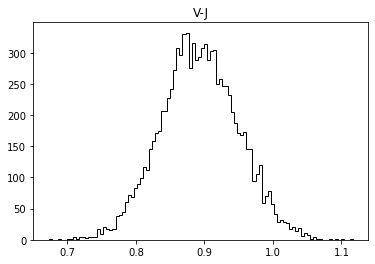

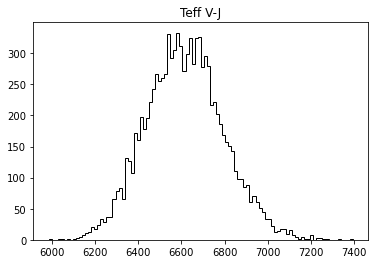

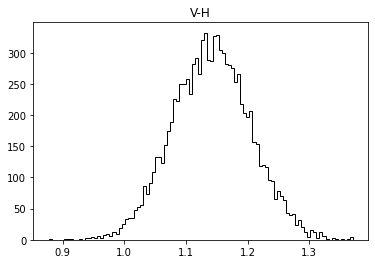

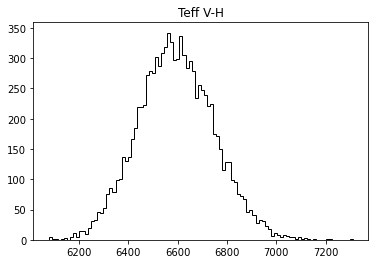

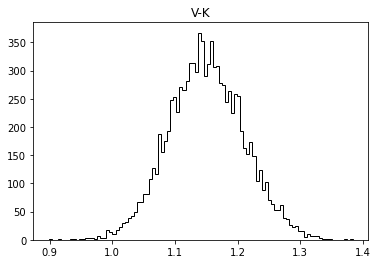

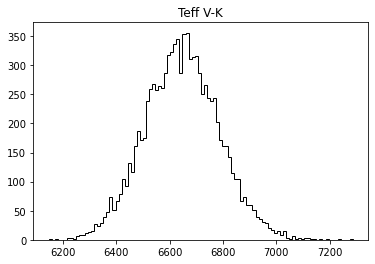

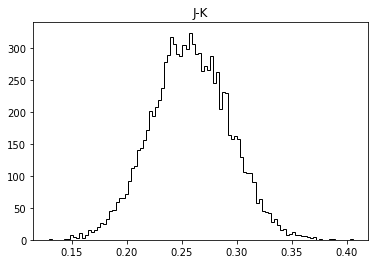

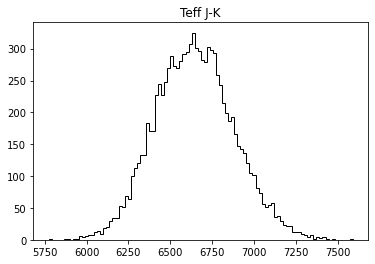

Star index: 26 has mean color outside of the applicable range!


In [558]:
df_ian_myeq['teff_V_J_loop0'], df_ian_myeq['e_teff_V_J_loop0'], df_ian_myeq['teff_V_H_loop0'], df_ian_myeq['e_teff_V_H_loop0'], \
df_ian_myeq['teff_V_K_loop0'], df_ian_myeq['e_teff_V_K_loop0'], df_ian_myeq['teff_J_K_loop0'], df_ian_myeq['e_teff_J_K_loop0'], \
df_ian_myeq['teff_loop0'], df_ian_myeq['e_teff_loop0'], df_ian_myeq['logg_loop0'], df_ian_myeq['e_logg_loop0'] \
= c10_color_feh_teff_fundamental_logg(df_ian_myeq['feh_ini'].values,np.ones(N_star)*0.03,df_ian_myeq['BCV_ini'].values,df_ian_myeq['e_BCV_ini'].values,df_ian_myeq,ian_eq=False)

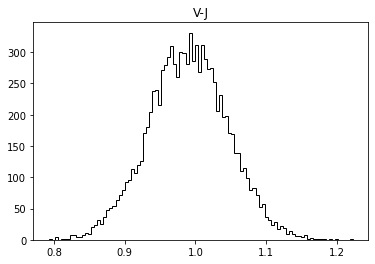

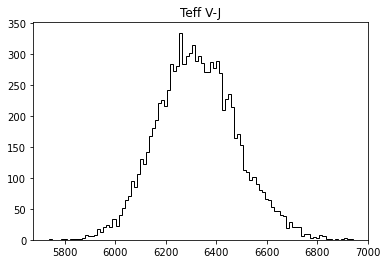

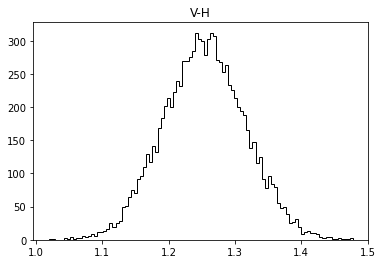

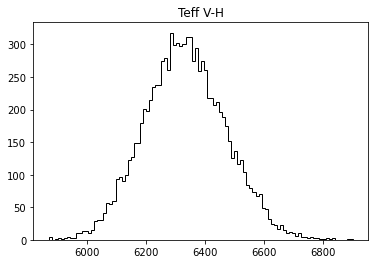

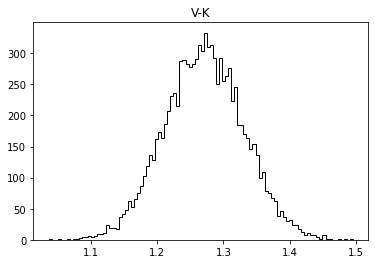

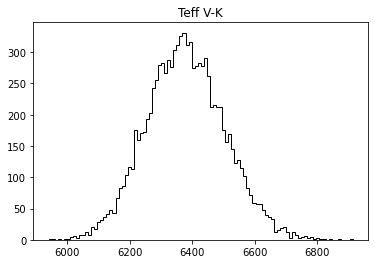

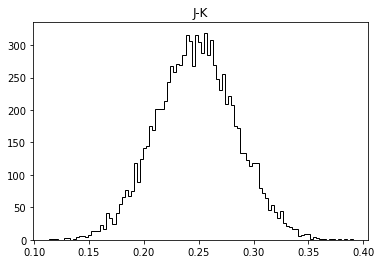

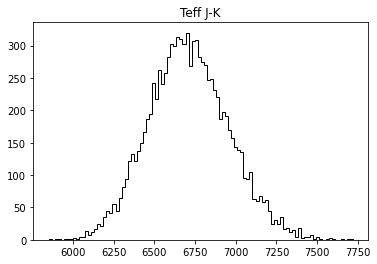

Star index: 26 has mean color outside of the applicable range!


In [559]:
df_ian_ianeq['teff_V_J_loop0'], df_ian_ianeq['e_teff_V_J_loop0'], df_ian_ianeq['teff_V_H_loop0'], df_ian_ianeq['e_teff_V_H_loop0'], \
df_ian_ianeq['teff_V_K_loop0'], df_ian_ianeq['e_teff_V_K_loop0'], df_ian_ianeq['teff_J_K_loop0'], df_ian_ianeq['e_teff_J_K_loop0'], \
df_ian_ianeq['teff_loop0'], df_ian_ianeq['e_teff_loop0'], df_ian_ianeq['logg_loop0'], df_ian_ianeq['e_logg_loop0'] \
= c10_color_feh_teff_fundamental_logg(df_ian_ianeq['feh_ini'].values,np.ones(N_star)*0.03,df_ian_ianeq['BCV_ini'].values,df_ian_ianeq['e_BCV_ini'].values,df_ian_ianeq,ian_eq=True)

In [550]:
df_ian_myeq.loc[:,['teff_V_J_loop0','e_teff_V_J_loop0','teff_V_H_loop0','e_teff_V_H_loop0','teff_V_K_loop0','e_teff_V_K_loop0','teff_J_K_loop0','e_teff_J_K_loop0','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0']]

,teff_V_J_loop0,e_teff_V_J_loop0,teff_V_H_loop0,e_teff_V_H_loop0,teff_V_K_loop0,e_teff_V_K_loop0,teff_J_K_loop0,e_teff_J_K_loop0,teff_loop0,e_teff_loop0,logg_loop0,e_logg_loop0
0,6614.583242,178.122906,6592.948601,151.818436,6647.207246,1.398460e+02,6649.293978,235.747650,6623.470811,27.804459,3.951895,0.081809
1,5885.176755,172.505428,5647.982169,101.847467,5700.355884,8.214607e+01,5397.852264,260.446305,5691.891434,109.092265,2.005343,0.099834
2,5723.246661,121.900281,5640.889340,98.888866,5674.327304,9.089043e+01,5726.514367,144.662626,5678.546260,37.864755,3.109295,0.092814
3,5713.634390,135.433445,5653.656465,100.990262,5654.400262,8.508281e+01,5604.063425,220.179814,5661.940959,30.595810,3.517394,0.093465
4,6614.455369,206.500344,6594.938733,157.914545,6645.437205,1.445992e+02,6646.662823,214.194444,6624.178192,26.310662,3.969576,0.083117
5,4500.570868,55.049177,4513.315387,64.674555,4518.821973,4.219871e+01,4821.506707,102.314055,4525.883332,72.147940,1.984095,0.116049
6,5043.073432,92.459332,4972.094060,75.627240,5004.541744,6.900769e+01,5114.186970,125.471893,5009.494454,43.416826,1.626041,0.169116
7,5197.640514,53.768274,5146.145801,42.003622,5094.386908,3.439517e+01,5023.727336,126.112659,5127.651847,49.474917,1.994153,0.114159
8,6880.604087,162.088796,6853.579195,127.130562,6768.440624,1.152876e+02,6467.641288,205.173801,6789.736375,129.882007,4.387471,0.088041
9,7263.241412,120.486785,7246.968574,99.764897,7200.634077,8.813504e+01,6877.442048,225.332297,7212.189897,94.855670,4.327245,0.079133


In [551]:
# Oupput the numbers
df_ian_myeq.to_csv('teff_logg/teff_logg_out_xoeq.csv',columns=['#NAME','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0'],index=False)

In [552]:
df_ian_ianeq.loc[:,['teff_V_J_loop0','e_teff_V_J_loop0','teff_V_H_loop0','e_teff_V_H_loop0','teff_V_K_loop0','e_teff_V_K_loop0','teff_J_K_loop0','e_teff_J_K_loop0','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0']]

,teff_V_J_loop0,e_teff_V_J_loop0,teff_V_H_loop0,e_teff_V_H_loop0,teff_V_K_loop0,e_teff_V_K_loop0,teff_J_K_loop0,e_teff_J_K_loop0,teff_loop0,e_teff_loop0,logg_loop0,e_logg_loop0
0,6321.654215,158.693495,6331.744537,137.411665,6378.941392,125.138653,6716.600053,242.715229,6378.534767,119.333342,3.886578,0.090271
1,5370.518967,136.170447,5218.421978,84.974417,5263.826395,67.975624,5521.942748,275.310463,5270.724884,73.567223,1.871966,0.099665
2,5345.696336,102.829643,5290.824467,86.187178,5330.227692,77.744217,5829.543438,146.650593,5355.497796,150.642229,3.008931,0.107361
3,5572.571110,124.941168,5528.392805,96.523886,5528.647961,80.489641,5637.032832,222.751472,5541.967025,31.580616,3.481318,0.094412
4,6364.441052,189.664032,6371.933629,147.438714,6418.073303,134.468647,6706.291062,215.984598,6425.648462,118.101886,3.914783,0.090172
5,4368.720927,50.368428,4377.678873,60.474076,4390.775429,39.122997,4869.780214,104.279131,4400.367326,107.515124,1.931934,0.122769
6,4932.837047,86.922950,4869.176982,71.692208,4904.078767,64.625209,5146.467640,127.365929,4913.343658,72.371960,1.597321,0.171975
7,5053.838714,49.785316,5012.015799,39.881314,4967.788651,31.692629,5063.537165,126.704294,4999.444085,39.881152,1.950151,0.115083
8,6493.451663,140.534379,6505.742786,112.366072,6429.774847,101.973431,6547.406592,206.726553,6475.882861,45.835038,4.304829,0.082555
9,6640.205478,97.773970,6690.349879,82.433120,6648.438773,73.113067,7016.147146,234.302961,6672.837239,79.139944,4.192371,0.082275


In [553]:
# Oupput the numbers
df_ian_ianeq.to_csv('teff_logg/teff_logg_out_iureq.csv',columns=['#NAME','teff_loop0','e_teff_loop0','logg_loop0','e_logg_loop0'],index=False)

In [531]:
# Plot the comparison
df_ian_sum = pd.read_csv('teff_logg/teff_logg_out_SUMMARY_standard.dat',delim_whitespace=True)
df_ian_sum = df_ian_sum.rename(columns={'err':'e_teff','err.1':'e_logg'})

In [532]:
df_ian_sum.columns

Index(['#STAR', 'Teff', 'e_teff', 'logg', 'e_logg', '[Fe/H]'], dtype='object')

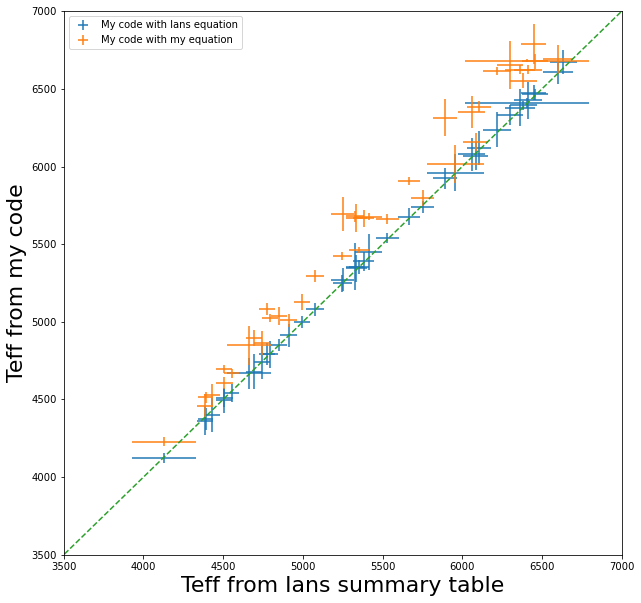

In [554]:
f = plt.figure(figsize=[10,10])
plt.errorbar(df_ian_sum['Teff'],df_ian_ianeq['teff_loop0'],xerr=df_ian_sum['e_teff'],yerr=df_ian_ianeq['e_teff_loop0'],ls='none',label='My code with Ian''s equation')
plt.errorbar(df_ian_sum['Teff'],df_ian_myeq['teff_loop0'],xerr=df_ian_sum['e_teff'],yerr=df_ian_myeq['e_teff_loop0'],ls='none',label='My code with my equation')
plt.xlabel('Teff from Ian''s summary table',fontsize=22)
plt.ylabel('Teff from my code',fontsize=22)
plt.legend()
plt.plot([3000,8000],[3000,8000],ls='--')
plt.xlim([3500,7000])
plt.ylim([3500,7000])
plt.show()
f.savefig('teff_logg/teff_compare.pdf')

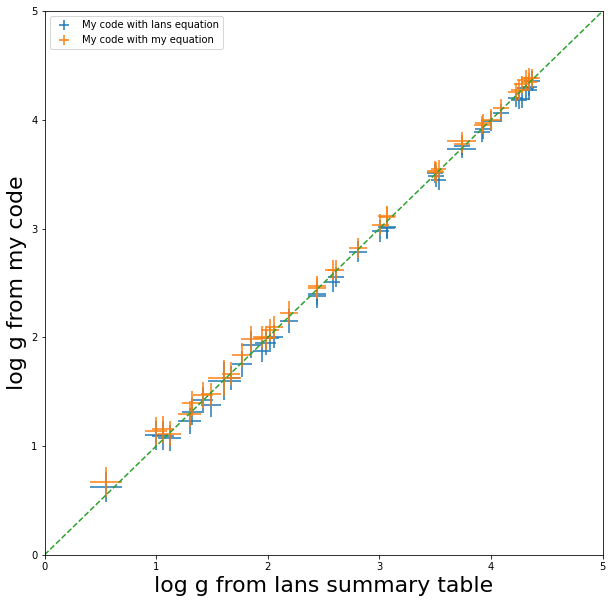

In [555]:
f = plt.figure(figsize=[10,10])
plt.errorbar(df_ian_sum['logg'],df_ian_ianeq['logg_loop0'],xerr=df_ian_sum['e_logg'],yerr=df_ian_ianeq['e_logg_loop0'],ls='none',label='My code with Ian''s equation')
plt.errorbar(df_ian_sum['logg'],df_ian_myeq['logg_loop0'],xerr=df_ian_sum['e_logg'],yerr=df_ian_myeq['e_logg_loop0'],ls='none',label='My code with my equation')
plt.xlabel('log g from Ian''s summary table',fontsize=22)
plt.ylabel('log g from my code',fontsize=22)
plt.legend()
plt.plot([0,5],[0,5],ls='--')
plt.xlim([0,5])
plt.ylim([0,5])
plt.show()
f.savefig('teff_logg/logg_compare.pdf')